## 2.0 Predictive Modeling: Vectorization, Baseline, and Tuning

### 1. Data Loading and Initial Setup
* *Load the processed `cleaned_news_data.csv`.*
* *Verify data types and class balance.*

### 2. Feature Vectorization (TF-IDF)
* Split Data: **Train-Test-Split** and Stratification.
* **TF-IDF Implementation** (Fit on Train, Transform on Test).
* *Check the shape and sparsity of the resulting feature matrix.*

### 3. Baseline Model: Logistic Regression
* Model Training and Initial Prediction.
* **Model Evaluation:** AUC-ROC and Classification Report.
* **Feature Importance Analysis** (Top 10 Positive/Negative Coefficients).

### 4. Advanced Modeling: Gradient Boosting (XGBoost)
* XGBoost Model Training (First Pass).
* *Comparison with Baseline AUC-ROC.*

### 5. Hyperparameter Tuning and Optimization
* Defining the Hyperparameter Search Space.
* **Grid Search or Randomized Search Implementation.**
* *Identify best model parameters.* 

### 6. Final Model Selection and Artifact Saving
* **Final Model Evaluation:** Metrics of the Tuned Model.
* **Confusion Matrix Visualization.**
* **Saving Model and Vectorizer** (`.joblib` or `.pkl`).

---

### 1. Data Loading and Feature Vectorization (TF-IDF)
This section loads cleaned data, splits it for testing, and converts the text into a numerical matrix.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load Cleaned Data
try:
    # Adjust path if necessary based on where you run the notebook
    df = pd.read_csv('../data/processed/cleaned_news_data.csv')
    print("Cleaned data loaded successfully.")
except FileNotFoundError:
    print("Error: Cleaned data file not found. Ensure it's saved in 'data/processed/'.")
    exit()

# Drop rows where cleaned_text might be unexpectedly null (if any were created by cleaning)
df.dropna(subset=['cleaned_text'], inplace=True)

# Define Features (X) and Target (y)
X = df['cleaned_text']
y = df['label']

Cleaned data loaded successfully.


In [9]:
# 2. Split Data: Train-Test-Split (80% Train, 20% Test)
# Use stratify to ensure the label balance is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# 3. Feature Vectorization (TF-IDF)
# max_features limits the vocabulary size, improving speed and reducing noise
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) 

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF Matrix Shape (Train): {X_train_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Test): {X_test_tfidf.shape}")


Training set size: 31280 samples
Testing set size: 7820 samples

TF-IDF Matrix Shape (Train): (31280, 5000)
TF-IDF Matrix Shape (Test): (7820, 5000)


### 2. Baseline Model: Logistic Regression 🎯
Now that your data is numerical, let's train the fast, interpretable Logistic Regression model.

In [10]:
# 1. Train the Baseline Model
print("\n--- Training Logistic Regression Baseline ---")
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# 2. Predict on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# 3. Model Evaluation (Refining P&S)
print("\n--- Baseline Model Performance (Logistic Regression) ---")

# AUC-ROC Score
auc_roc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC-ROC Score: {auc_roc_lr:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Fake (0)', 'Real (1)']))


--- Training Logistic Regression Baseline ---

--- Baseline Model Performance (Logistic Regression) ---
AUC-ROC Score: 0.9992

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.99      0.98      0.99      3581
    Real (1)       0.99      0.99      0.99      4239

    accuracy                           0.99      7820
   macro avg       0.99      0.99      0.99      7820
weighted avg       0.99      0.99      0.99      7820



### Interpretation Check (Critical)

This step extracts the top words the model learned.

In [11]:
# Get feature names and model coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Combine names and coefficients into a DataFrame
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort by coefficient magnitude
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)

print("\n--- Top 10 Features Predicting REAL News (Positive Coefficients) ---")
print(coef_df.head(10))

print("\n--- Top 10 Features Predicting FAKE News (Negative Coefficients) ---")
print(coef_df.tail(10))


--- Top 10 Features Predicting REAL News (Positive Coefficients) ---
                 feature  coefficient
3690             reuters    20.177554
3799                said    15.892675
4838  washington reuters     8.318887
3292    president donald     4.899516
4835          washington     4.561549
4634             tuesday     4.407608
4855           wednesday     4.373771
4469            thursday     3.872308
3694   reuters president     3.736248
1760              friday     3.572645

--- Top 10 Features Predicting FAKE News (Negative Coefficients) ---
              feature  coefficient
2797               mr    -3.840364
2950            obama    -4.305355
1467             even    -4.313955
2094        image via    -4.628465
3299  president trump    -4.875225
1992          hillary    -4.986163
1848              gop    -5.207968
2092            image    -8.021665
4754              via    -8.112969
4766            video    -8.513280


### 4. Advanced Modeling: Gradient Boosting (XGBoost)

XGBoost is often superior for structured data and can handle the complexity of your sparse TF-IDF features better than a linear model. We'll train a basic version first and compare its performance to the baseline.
Python

In [13]:
# Import the XGBoost classifier
import xgboost as xgb

print("\n--- Training XGBoost Model (First Pass) ---")

# Initialize and train the XGBoost classifier
# Use verbosity=0 to suppress excessive output during training
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42, 
    n_estimators=100
)

# NOTE: Training time for XGBoost on sparse data can be significant
xgb_model.fit(X_train_tfidf, y_train)

# Predict probabilities and calculate AUC-ROC
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]
auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\nBaseline Logistic Regression AUC-ROC: {auc_roc_lr:.4f}")
print(f"XGBoost First Pass AUC-ROC: {auc_roc_xgb:.4f}")

if auc_roc_xgb > auc_roc_lr:
    print("✅ XGBoost provides an immediate improvement over the baseline!")
else:
    print("⚠️ XGBoost is slightly behind the baseline, but tuning may change this.")



--- Training XGBoost Model (First Pass) ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:33:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Baseline Logistic Regression AUC-ROC: 0.9992
XGBoost First Pass AUC-ROC: 0.9995
✅ XGBoost provides an immediate improvement over the baseline!


### 5. Hyperparameter Tuning and Optimization

Use Randomized Search to quickly find a good combination of parameters for the XGBoost model, as a full Grid Search on text data is often too time-consuming.
Python


In [14]:
from sklearn.model_selection import RandomizedSearchCV

print("\n--- Hyperparameter Tuning (Randomized Search) ---")

# Define a reasonable search space for XGBoost parameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [5, 7, 9],           # Maximum tree depth
    'learning_rate': [0.05, 0.1, 0.2], # Step size shrinkage
    'gamma': [0, 0.1, 0.5],           # Minimum loss reduction required to make a further partition
    'subsample': [0.7, 0.9, 1.0]      # Subsample ratio of the training instances
}

# Initialize Randomized Search CV
# n_iter: number of parameter settings that are sampled.
# scoring: Use AUC-ROC as the primary tuning metric.
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=20, # Test 20 random combinations
    scoring='roc_auc',
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search on the training data
random_search.fit(X_train_tfidf, y_train)

# Get the best estimator and score
best_xgb = random_search.best_estimator_
best_score = random_search.best_score_

print(f"\n✅ Best Cross-Validation AUC-ROC Score: {best_score:.4f}")
print(f"Optimal Parameters: {random_search.best_params_}")


--- Hyperparameter Tuning (Randomized Search) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:33:41] WARN

[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:35:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:35:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:36:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time= 3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time= 3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:37:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9; total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:37:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9; total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:38:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9; total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.9; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:38:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.9; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:39:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.9; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.7; total time= 6.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:40:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.7; total time= 7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:40:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.7; total time= 7.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:40:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.7; total time= 1.8min
[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.7; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time= 3.5min
[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time= 3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.9; total time= 4.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.9; total time= 4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.9; total time= 4.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:43:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.7; total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time= 2.7min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time= 3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:45:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time= 2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:48:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time= 3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time= 3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1.0; total time= 3.1min
[CV] END gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1.0; total time= 3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:50:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1.0; total time= 3.3min
[CV] END gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 2.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 2.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 2.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time= 1.7min
[CV] END gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time= 1.8min
[CV] END gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time= 2.9min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7; total time= 4.5min
[CV] END gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time= 2.6min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7; total time= 4.7min
[CV] END gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time= 2.3min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7; total time= 4.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:55:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Cross-Validation AUC-ROC Score: 0.9998
Optimal Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0}


### 6. Final Model Selection and Artifact Saving

Evaluate the final best model on the test set and save the key artifacts needed for deployment.

In [15]:
from sklearn.metrics import confusion_matrix
from joblib import dump # Use joblib for efficient saving of large models/vectorizers
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Final Model Evaluation (on Unseen Test Set)
print("\n--- Final Tuned Model Performance on Test Set ---")

# Predict using the best model found during tuning
y_pred_tuned = best_xgb.predict(X_test_tfidf)
y_pred_proba_tuned = best_xgb.predict_proba(X_test_tfidf)[:, 1]

# Final AUC-ROC Score
final_auc_roc = roc_auc_score(y_test, y_pred_proba_tuned)
print(f"Final Tuned XGBoost AUC-ROC: {final_auc_roc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Fake (0)', 'Real (1)']))



--- Final Tuned Model Performance on Test Set ---
Final Tuned XGBoost AUC-ROC: 0.9997

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       1.00      0.99      1.00      3581
    Real (1)       1.00      1.00      1.00      4239

    accuracy                           1.00      7820
   macro avg       1.00      1.00      1.00      7820
weighted avg       1.00      1.00      1.00      7820



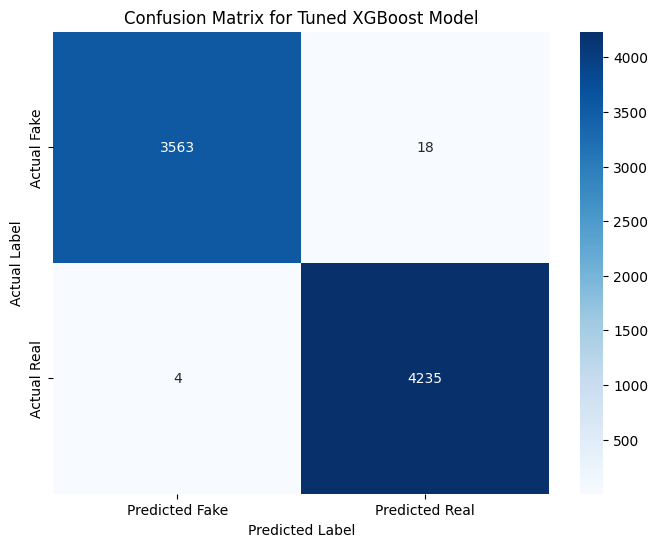

In [16]:
# 2. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Fake', 'Predicted Real'], 
            yticklabels=['Actual Fake', 'Actual Real'])
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
# 3. Saving Model and Vectorizer Artifacts
print("\n--- Saving Model Artifacts ---")

import os

# Create a models directory if it doesn't exist
os.makedirs('../models', exist_ok=True) 

# Save the fitted TF-IDF Vectorizer
dump(tfidf_vectorizer, '../models/tfidf_vectorizer.joblib')
print("Saved: tfidf_vectorizer.joblib")

# Save the final Tuned Model
dump(best_xgb, '../models/final_xgb_model.joblib')
print("Saved: final_xgb_model.joblib")


--- Saving Model Artifacts ---
Saved: tfidf_vectorizer.joblib
Saved: final_xgb_model.joblib
